In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from math import sqrt
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

# Исследуем месячное производство пива в Австрии 

In [4]:
beer = pd.read_excel('Задания_1_2.xlsx', index_col = False)
beer

,Date,series1
0,2015-01-01,1006.699649
1,2015-01-02,3197.751826
2,2015-01-03,3217.491035
3,2015-01-04,2151.573759
4,2015-01-05,4243.929892
...,...,...
1637,2019-06-26,4007.059387
1638,2019-06-27,4836.106157
1639,2019-06-28,4895.323783
1640,2019-06-29,4086.016222


In [5]:
beerProd = beer['series1']

# В качестве модели Machine Learning возьмем Random Forest Regressor

In [10]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    test_index = int(len(data)*(1-test_size))
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data['series1'].shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Date"], axis=1)
    X_train = data.loc[:test_index].drop(["series1"], axis=1)
    y_train = data.loc[:test_index]["series1"]
    X_test = data.loc[test_index:].drop(["series1"], axis=1)
    y_test = data.loc[test_index:]["series1"]
    
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = prepareData(beer, lag_start=1, lag_end=25, test_size=0.3)

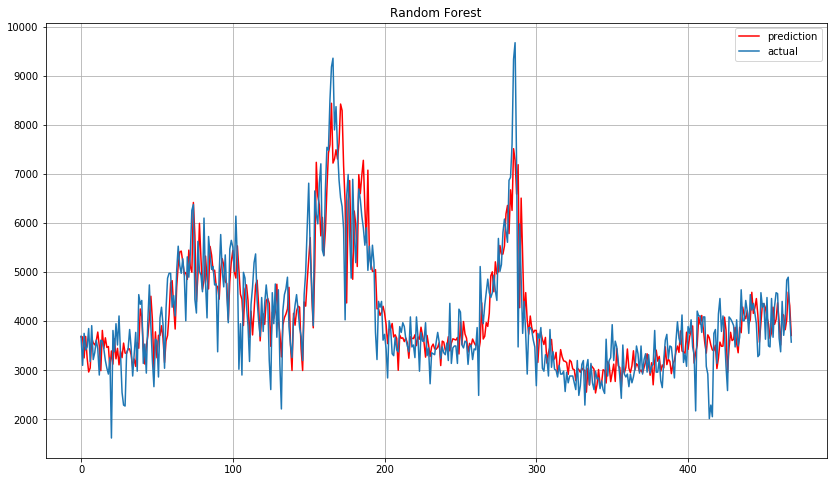

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)
prediction_rf = rf.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction_rf, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Random Forest")
plt.grid(True);

# Ревизорро огорчило, но линейная регрессия отработала ещё хуже, нужен на подмогу гридсерч

In [14]:
mean_squared_error(y_test, prediction_rf, squared=False)

656.2715171246358

# Hidden Markov Model

In [15]:
from hmmlearn.hmm import GaussianHMM
values = beerProd.values.reshape(-1,1)
for n in range(1, 18):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 -14021.614656333271
2 -13319.108642498344
3 -13159.875916828703
4 -13049.284507457474
5 -12996.530052013148
6 -12952.372697600787
7 -12942.010019164867
8 -12902.962047511732
9 -12891.059608056767
10 -12848.16584259318
11 -12836.232001108752
12 -12810.20914869417
13 -12789.419564400423
14 -12793.896798253447
15 -12767.066387604733
16 -12761.426520232575
17 -12754.110747598173


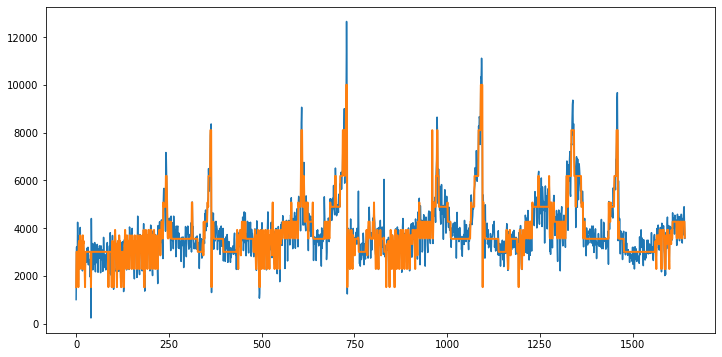

In [16]:
model = GaussianHMM(n_components=17,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=2)

In [17]:
test_index = values.shape[0] - 40
train = values[:test_index]
test = values[test_index:]

In [18]:
model = GaussianHMM(n_components=17,
                        covariance_type="diag",
                        n_iter=1500)
model.fit(train)

GaussianHMM(n_components=17, n_iter=1500)

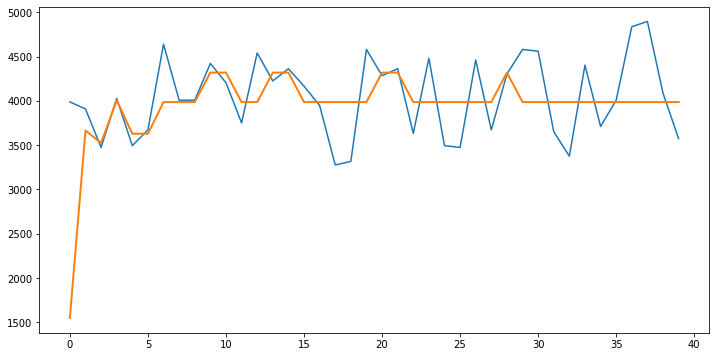

In [19]:
labels = model.predict(test)
means = np.zeros_like(test)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(test)
plt.plot(means, linewidth=2)

# Визуально выглядит лучше

In [20]:
mean_squared_error(means, test, squared = False)

559.7634896515918

# Проверяем ряд на стационарность

In [21]:
# проверка стационарности Дики-Фуллера
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [22]:
# Time-series plot
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        # qqplot для определения нормальности распределения остатков
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

Results of Dickey-Fuller Test:
Test Statistic                   -5.496714
p-value                           0.000002
#Lags Used                       21.000000
Number of Observations Used    1620.000000
Critical Value (1%)              -3.434393
Critical Value (5%)              -2.863326
Critical Value (10%)             -2.567721
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                   -5.496714
p-value                           0.000002
#Lags Used                       21.000000
Number of Observations Used    1620.000000
Critical Value (1%)              -3.434393
Critical Value (5%)              -2.863326
Critical Value (10%)             -2.567721
dtype: float64


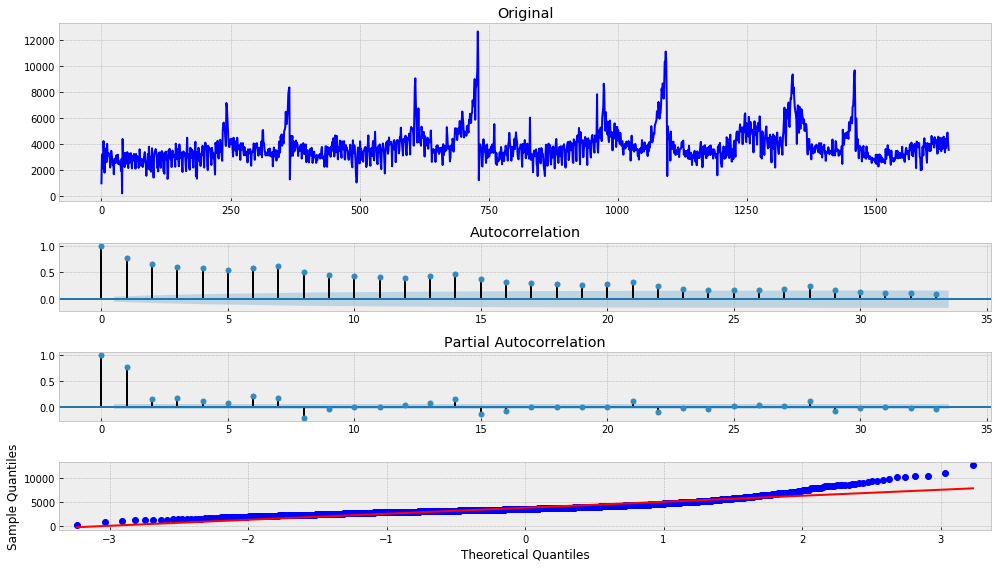

In [23]:
test_stationarity(beerProd)
tsplot(beerProd)

# Ряд нестационарен, также в нём есть сезонность, поэтому сделаем небольшие манипуляции для исправления ситуации

In [24]:
beerProd_changed = boxcox(beerProd, 1)
beerProd_changed = beerProd_changed[12:] - beerProd_changed[:-12]
beerProd_changed = np.diff(beerProd_changed, 1)

Results of Dickey-Fuller Test:
Test Statistic                -1.459745e+01
p-value                        4.218225e-27
#Lags Used                     2.400000e+01
Number of Observations Used    1.604000e+03
Critical Value (1%)           -3.434433e+00
Critical Value (5%)           -2.863344e+00
Critical Value (10%)          -2.567730e+00
dtype: float64


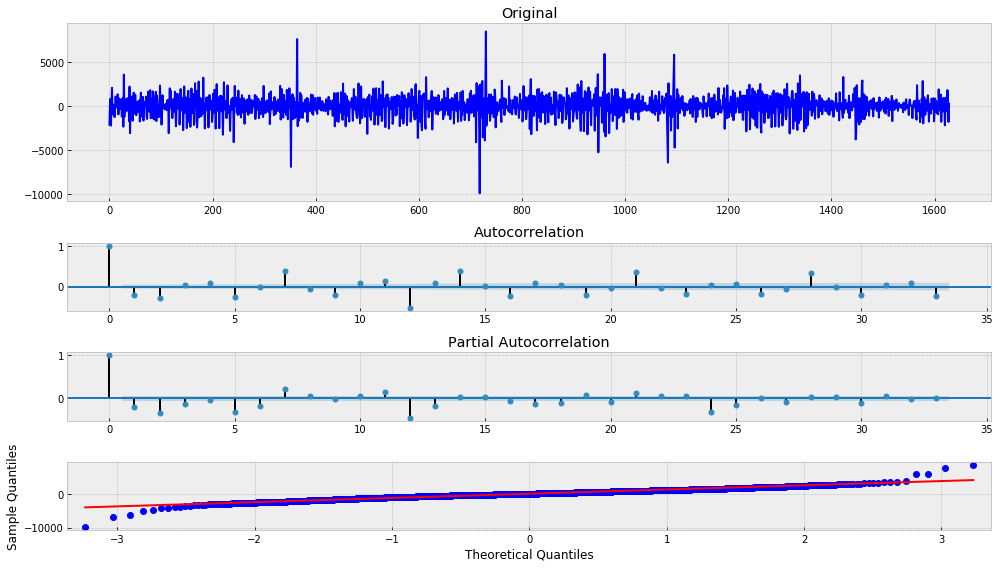

In [25]:
tsplot(beerProd_changed)

# Ряд стал стационарным, можно применять Arima

Results of Dickey-Fuller Test:
Test Statistic                -1.288722e+01
p-value                        4.527285e-24
#Lags Used                     2.500000e+01
Number of Observations Used    1.603000e+03
Critical Value (1%)           -3.434436e+00
Critical Value (5%)           -2.863345e+00
Critical Value (10%)          -2.567731e+00
dtype: float64


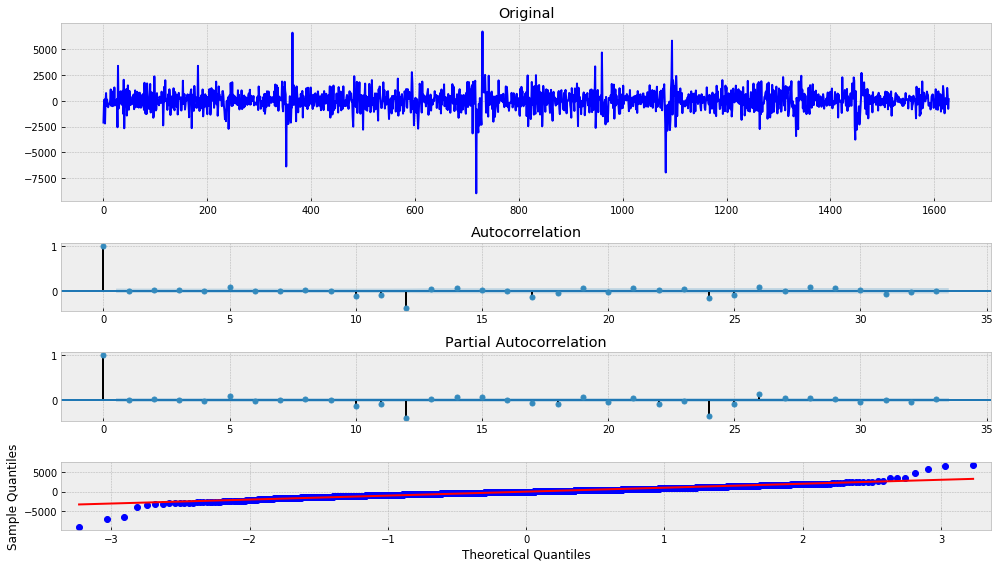

In [26]:
arima_model = smt.ARIMA(beerProd_changed, order=(5,0,3)).fit(method='mle', trend='nc')
tsplot(arima_model.resid)

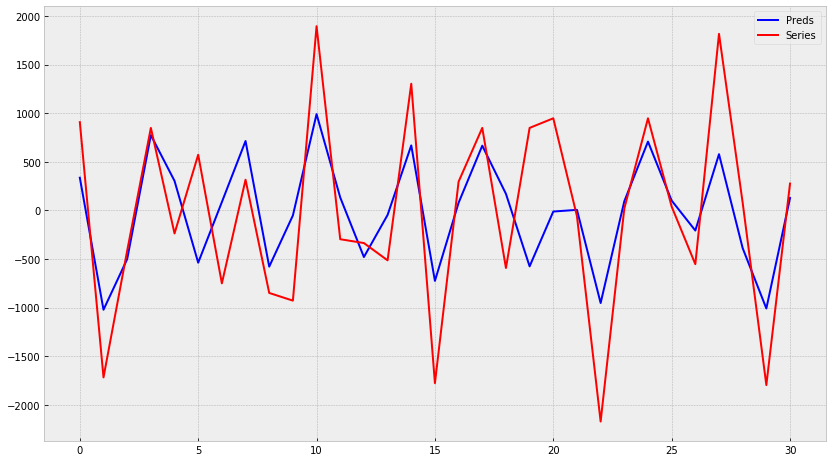

In [27]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(arima_model.predict(len(beerProd_changed[:-31]),len(beerProd_changed[:-31])+30),color="blue",label='Preds')
    plt.plot(beerProd_changed[-31:], color='red', label='Series')
    plt.legend()
    plt.show()

In [28]:
np.sqrt(np.sum((arima_model.predict(len(beerProd_changed[:-31]),len(beerProd_changed[:-31])+30)-beerProd_changed[-31:])**2))/30

126.81391024806884

# Вывод: в конкретно данном датасете лучше всего справилась с работой Arima, но самый глобальный вывод: предсказать производство пива в Австрии - не самое благодарное занятие. С 1950 года производственные мощности, естественно увеличились, также на производство очень влияет урожайность и другие факторы. Пейте пиво!